# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "C:/Users/User/Downloads/bi-2021-ml-competitions-dota2"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [7]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")
X

array([[6.580e+02, 4.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.100e+01, 2.300e+01, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.600e+02, 2.200e+01, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.002e+03, 4.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.770e+02, 2.200e+01, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [6.430e+02, 2.200e+01, 7.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [10]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

Wall time: 12.5 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [10]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [11]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [12]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [13]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [14]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-23_11-51-43.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [9]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [16]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

Wall time: 1min 13s


In [17]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [18]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [10]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [11]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [12]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

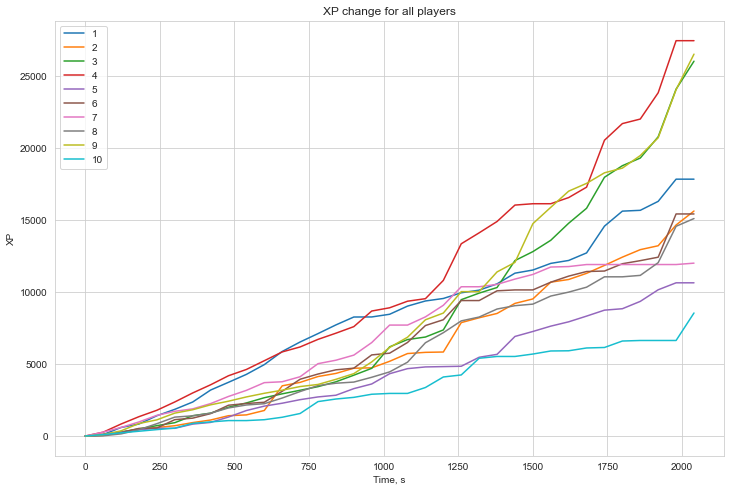

In [13]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [14]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

Подумайте об установке ujson, чтобы работать с JSON объектами быстрее


#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [15]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [16]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

In [18]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [19]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

NameError: name 'rf_model' is not defined

In [28]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

# Мои попытки
## Пытаюсь преобразовать данные

In [29]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


In [30]:
target = pd.Series(df_train_targets['radiant_win'].map({True: 1, False: 0}))

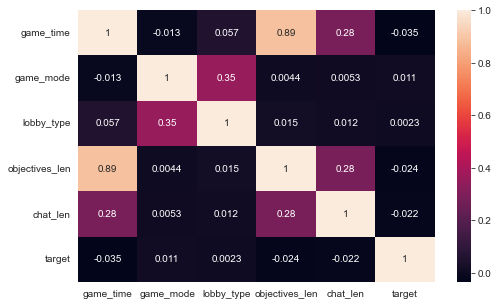

In [40]:
first_features = df_train_features[['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len']].copy()
first_features['target'] = target
plt.figure(figsize=(8, 5));
ax = sns.heatmap(first_features.corr(),annot=True,)

Видно, что Game time и Objectives len сильно скоррелированы, а с таргетом вообще никто из них не коррелирует. Можно будет их дропнуть

Дальше я решила изучить скоррелированность признаков с таргетом

In [32]:
fetures = list(df_train_features)
y= df_train_targets["radiant_win"]
y = pd.get_dummies(y)
y = y[False]
corrs = []
for i in range(0,245):
    d = df_train_features.iloc[:, i]
    correlation = d.corr(y)
    corrs.append(correlation)
my_data = pd.DataFrame({'features': fetures, 'corr': corrs})

In [33]:

my_data.sort_values(by='corr', ascending=False).head(10)

,features,corr
55,r3_deaths,0.145709
79,r4_deaths,0.144506
103,r5_deaths,0.142165
7,r1_deaths,0.141315
31,r2_deaths,0.137499
169,d2_towers_killed,0.131626
241,d5_towers_killed,0.130541
222,d5_kills,0.128652
193,d3_towers_killed,0.128467
198,d4_kills,0.128294


In [34]:
my_data.sort_values(by='corr', ascending=True).head(10)

,features,corr
18,r1_y,-0.202537
162,d2_y,-0.202515
42,r2_y,-0.202448
186,d3_y,-0.202387
66,r3_y,-0.202271
90,r4_y,-0.199185
210,d4_y,-0.198917
114,r5_y,-0.198795
234,d5_y,-0.197397
138,d1_y,-0.196519


Сначала я решила, что нужно только те признаки, которые коррелируют с таргетом более-менее,   объеддинять в суммы для двх команд и сравнивать. Потом я решила, что попробую так сделать со всеми признаками, кроме id героя. 
Копирую расширенную таблицу: 

In [254]:
df_train_features_extended_Livanova= df_train_features_extended.copy()
df_train_features_extended_Livanova.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


создаю колонки-суммы по командам, а отдельные колонки по героям убираю

In [255]:
df_train_features_extended_Livanova['r_death_sum'] = df_train_features_extended_Livanova[['r1_deaths','r2_deaths','r3_deaths','r4_deaths', 'r5_deaths']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_deaths','r2_deaths','r3_deaths','r4_deaths', 'r5_deaths'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_death_sum'] = df_train_features_extended_Livanova[['d1_deaths','d2_deaths','d3_deaths','d4_deaths', 'd5_deaths']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_deaths','d2_deaths','d3_deaths','d4_deaths', 'd5_deaths'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_kills_sum'] = df_train_features_extended_Livanova[['d1_kills','d2_kills','d3_kills','d4_kills', 'd5_kills']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_kills','d2_kills','d3_kills','d4_kills', 'd5_kills'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_kills_sum'] = df_train_features_extended_Livanova[['r1_kills','r2_kills','r3_kills','r4_kills', 'r5_kills']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_kills','r2_kills','r3_kills','r4_kills', 'r5_kills'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_assists_sum'] = df_train_features_extended_Livanova[['d1_assists','d2_assists','d3_assists','d4_assists', 'd5_assists']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_assists','d2_assists','d3_assists','d4_assists', 'd5_assists'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_assists_sum'] = df_train_features_extended_Livanova[['r1_assists','r2_assists','r3_assists','r4_assists', 'r5_assists']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_assists','r2_assists','r3_assists','r4_assists', 'r5_assists'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_rune_pickups_sum'] = df_train_features_extended_Livanova[['d1_rune_pickups','d2_rune_pickups','d3_rune_pickups','d4_rune_pickups', 'd5_rune_pickups']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_rune_pickups','d2_rune_pickups','d3_rune_pickups','d4_rune_pickups', 'd5_rune_pickups'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_rune_pickups_sum'] = df_train_features_extended_Livanova[['r1_rune_pickups','r2_rune_pickups','r3_rune_pickups','r4_rune_pickups', 'r5_rune_pickups']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_rune_pickups','r2_rune_pickups','r3_rune_pickups','r4_rune_pickups', 'r5_rune_pickups'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_gold_sum'] = df_train_features_extended_Livanova[['d1_gold','d2_gold','d3_gold','d4_gold', 'd5_gold']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_gold','d2_gold','d3_gold','d4_gold', 'd5_gold'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_gold_sum'] = df_train_features_extended_Livanova[['r1_gold','r2_gold','r3_gold','r4_gold', 'r5_gold']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_gold','r2_gold','r3_gold','r4_gold', 'r5_gold'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_x'] = df_train_features_extended_Livanova[['d1_x','d2_x','d3_x','d4_x', 'd5_x']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_x','d2_x','d3_x','d4_x', 'd5_x'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_x'] = df_train_features_extended_Livanova[['r1_x','r2_x','r3_x','r4_x', 'r5_x']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_x','r2_x','r3_x','r4_x', 'r5_x'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_y'] = df_train_features_extended_Livanova[['d1_y','d2_y','d3_y','d4_y', 'd5_y']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_y','d2_y','d3_y','d4_y', 'd5_y'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_y'] = df_train_features_extended_Livanova[['r1_y','r2_y','r3_y','r4_y', 'r5_y']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_y','r2_y','r3_y','r4_y', 'r5_y'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_health_sum'] = df_train_features_extended_Livanova[['d1_health','d2_health','d3_health','d4_health', 'd5_health']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_health','d2_health','d3_health','d4_health', 'd5_health'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_health_sum'] = df_train_features_extended_Livanova[['r1_health','r2_health','r3_health','r4_health', 'r5_health']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_health','r2_health','r3_health','r4_health', 'r5_health'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_xp_sum'] = df_train_features_extended_Livanova[['d1_xp','d2_xp','d3_xp','d4_xp', 'd5_xp']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_xp','d2_xp','d3_xp','d4_xp', 'd5_xp'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_xp_sum'] = df_train_features_extended_Livanova[['r1_xp','r2_xp','r3_xp','r4_xp', 'r5_xp']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_xp','r2_xp','r3_xp','r4_xp', 'r5_xp'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_level_sum'] = df_train_features_extended_Livanova[['r1_level','r2_level','r3_level','r4_level', 'r5_level']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_level','r2_level','r3_level','r4_level', 'r5_level'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_level_sum'] = df_train_features_extended_Livanova[['d1_level','d2_level','d3_level','d4_level', 'd5_level']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_level','d2_level','d3_level','d4_level', 'd5_level'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_towers_killed_sum'] = df_train_features_extended_Livanova[['r1_towers_killed','r2_towers_killed','r3_towers_killed','r4_towers_killed', 'r5_towers_killed']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_towers_killed','r2_towers_killed','r3_towers_killed','r4_towers_killed', 'r5_towers_killed'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_towers_killed_sum'] = df_train_features_extended_Livanova[['d1_towers_killed','d2_towers_killed','d3_towers_killed','d4_towers_killed', 'd5_towers_killed']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_towers_killed','d2_towers_killed','d3_towers_killed','d4_towers_killed', 'd5_towers_killed'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_denies_sum'] = df_train_features_extended_Livanova[['d1_denies','d2_denies','d3_denies','d4_denies', 'd5_denies']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_denies','d2_denies','d3_denies','d4_denies', 'd5_denies'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_denies_sum'] = df_train_features_extended_Livanova[['r1_denies','r2_denies','r3_denies','r4_denies', 'r5_denies']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_denies','r2_denies','r3_denies','r4_denies', 'r5_denies'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_firstblood_claimed_sum'] = df_train_features_extended_Livanova[['r1_firstblood_claimed','r2_firstblood_claimed','r3_firstblood_claimed','r4_firstblood_claimed', 'r5_firstblood_claimed']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_firstblood_claimed','r2_firstblood_claimed','r3_firstblood_claimed','r4_firstblood_claimed', 'r5_firstblood_claimed'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_firstblood_claimed_sum'] = df_train_features_extended_Livanova[['d1_firstblood_claimed','d2_firstblood_claimed','d3_firstblood_claimed','d4_firstblood_claimed', 'd5_firstblood_claimed']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_firstblood_claimed','d2_firstblood_claimed','d3_firstblood_claimed','d4_firstblood_claimed', 'd5_firstblood_claimed'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_roshans_killed_sum'] = df_train_features_extended_Livanova[['d1_roshans_killed','d2_roshans_killed','d3_roshans_killed','d4_roshans_killed', 'd5_roshans_killed']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_roshans_killed','d2_roshans_killed','d3_roshans_killed','d4_roshans_killed', 'd5_roshans_killed'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_roshans_killed_sum'] = df_train_features_extended_Livanova[['r1_roshans_killed','r2_roshans_killed','r3_roshans_killed','r4_roshans_killed', 'r5_roshans_killed']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_roshans_killed','r2_roshans_killed','r3_roshans_killed','r4_roshans_killed', 'r5_roshans_killed'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_max_mana_sum'] = df_train_features_extended_Livanova[['r1_max_mana','r2_max_mana','r3_max_mana','r4_max_mana', 'r5_max_mana']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_max_mana','r2_max_mana','r3_max_mana','r4_max_mana', 'r5_max_mana'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_max_mana_sum'] = df_train_features_extended_Livanova[['d1_max_mana','d2_max_mana','d3_max_mana','d4_max_mana', 'd5_max_mana']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_max_mana','d2_max_mana','d3_max_mana','d4_max_mana', 'd5_max_mana'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_max_health_sum'] = df_train_features_extended_Livanova[['d1_max_health','d2_max_health','d3_max_health','d4_max_health', 'd5_max_health']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_max_health','d2_max_health','d3_max_health','d4_max_health', 'd5_max_health'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_max_health_sum'] = df_train_features_extended_Livanova[['r1_max_health','r2_max_health','r3_max_health','r4_max_health', 'r5_max_health']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_max_health','r2_max_health','r3_max_health','r4_max_health', 'r5_max_health'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_lh'] = df_train_features_extended_Livanova[['r1_lh','r2_lh','r3_lh','r4_lh', 'r5_lh']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_lh','r2_lh','r3_lh','r4_lh', 'r5_lh'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_lh'] = df_train_features_extended_Livanova[['d1_lh','d2_lh','d3_lh','d4_lh', 'd5_lh']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_lh','d2_lh','d3_lh','d4_lh', 'd5_lh'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_creeps_stacked'] = df_train_features_extended_Livanova[['r1_creeps_stacked','r2_creeps_stacked','r3_creeps_stacked','r4_creeps_stacked', 'r5_creeps_stacked']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_creeps_stacked','r2_creeps_stacked','r3_creeps_stacked','r4_creeps_stacked', 'r5_creeps_stacked'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_creeps_stacked'] = df_train_features_extended_Livanova[['d1_creeps_stacked','d2_creeps_stacked','d3_creeps_stacked','d4_creeps_stacked', 'd5_creeps_stacked']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_creeps_stacked','d2_creeps_stacked','d3_creeps_stacked','d4_creeps_stacked', 'd5_creeps_stacked'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_camps_stacked'] = df_train_features_extended_Livanova[['d1_camps_stacked','d2_camps_stacked','d3_camps_stacked','d4_camps_stacked', 'd5_camps_stacked']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_camps_stacked','d2_camps_stacked','d3_camps_stacked','d4_camps_stacked', 'd5_camps_stacked'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_camps_stacked'] = df_train_features_extended_Livanova[['r1_camps_stacked','r2_camps_stacked','r3_camps_stacked','r4_camps_stacked', 'r5_camps_stacked']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_camps_stacked','r2_camps_stacked','r3_camps_stacked','r4_camps_stacked', 'r5_camps_stacked'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_teamfight_participation'] = df_train_features_extended_Livanova[['r1_teamfight_participation','r2_teamfight_participation','r3_teamfight_participation','r4_teamfight_participation', 'r5_teamfight_participation']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_teamfight_participation','r2_teamfight_participation','r3_teamfight_participation','r4_teamfight_participation', 'r5_teamfight_participation'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_teamfight_participation'] = df_train_features_extended_Livanova[['d1_teamfight_participation','d2_teamfight_participation','d3_teamfight_participation','d4_teamfight_participation', 'd5_teamfight_participation']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_teamfight_participation','d2_teamfight_participation','d3_teamfight_participation','d4_teamfight_participation', 'd5_teamfight_participation'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_obs_placed'] = df_train_features_extended_Livanova[['d1_obs_placed','d2_obs_placed','d3_obs_placed','d4_obs_placed', 'd5_obs_placed']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_obs_placed','d2_obs_placed','d3_obs_placed','d4_obs_placed', 'd5_obs_placed'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_obs_placed'] = df_train_features_extended_Livanova[['r1_obs_placed','r2_obs_placed','r3_obs_placed','r4_obs_placed', 'r5_obs_placed']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_obs_placed','r2_obs_placed','r3_obs_placed','r4_obs_placed', 'r5_obs_placed'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_sen_placed'] = df_train_features_extended_Livanova[['r1_sen_placed','r2_sen_placed','r3_sen_placed','r4_sen_placed', 'r5_sen_placed']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_sen_placed','r2_sen_placed','r3_sen_placed','r4_sen_placed', 'r5_sen_placed'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_sen_placed'] = df_train_features_extended_Livanova[['d1_sen_placed','d2_sen_placed','d3_sen_placed','d4_sen_placed', 'd5_sen_placed']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_sen_placed','d2_sen_placed','d3_sen_placed','d4_sen_placed', 'd5_sen_placed'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['r_stuns'] = df_train_features_extended_Livanova[['r1_stuns','r2_stuns','r3_stuns','r4_stuns', 'r5_stuns']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r1_stuns','r2_stuns','r3_stuns','r4_stuns', 'r5_stuns'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['d_stuns'] = df_train_features_extended_Livanova[['d1_stuns','d2_stuns','d3_stuns','d4_stuns', 'd5_stuns']].sum(axis=1)
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d1_stuns','d2_stuns','d3_stuns','d4_stuns', 'd5_stuns'], axis=1)
df_train_features_extended_Livanova.head()


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,...,d_camps_stacked,r_camps_stacked,r_teamfight_participation,d_teamfight_participation,d_obs_placed,r_obs_placed,r_sen_placed,d_sen_placed,r_stuns,d_stuns
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,96,27,63,89,...,2,1,1.875000,1.5,5,4,3,2,42.060296,3.532506
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,51,44,49,53,...,0,0,0.000000,0.0,0,0,0,0,0.000000,0.000000
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,10,81,98,119,...,0,0,0.000000,0.0,0,1,0,0,7.231550,0.000000
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,71,44,35,108,...,0,0,2.100000,2.0,7,6,2,1,63.184530,48.488246
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,49,91,114,50,...,2,5,2.166667,2.0,4,2,0,1,5.332095,46.016229


Теперь у меня всего 64 колонки, и убраны все индивидуальные показатели 1-5 (кроме id, с ними я чуть позже разберусь). Узнаю предсказание случайного леса после такой манипуляции.

In [22]:
X = df_train_features_extended_Livanova.values
y = df_train_targets["radiant_win"].values.astype("int8")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7904673598005749


Ну в целом уже получше

Введу KDA, по идее этот показатель должен сработать лучше, чем отдельно kills death assists. Чтобы избежать деления на ноль, если death=0, в этих случаях буду делить на 1. 

In [256]:
r_KDA = []
for i in range(0, len(df_train_features_extended_Livanova)):
    if df_train_features_extended_Livanova.r_death_sum[i] == 0:
        r_KDA.append(df_train_features_extended_Livanova.r_kills_sum[i] + df_train_features_extended_Livanova.r_assists_sum[i])
    else:
        r_KDA.append((df_train_features_extended_Livanova.r_kills_sum[i] + df_train_features_extended_Livanova.r_assists_sum[i])/df_train_features_extended_Livanova.r_death_sum[i])
    
df_train_features_extended_Livanova['r_KDA']=r_KDA

d_KDA = []
for i in range(0, len(df_train_features_extended_Livanova)):
    if df_train_features_extended_Livanova.d_death_sum[i] == 0:
        d_KDA.append(df_train_features_extended_Livanova.d_kills_sum[i] + df_train_features_extended_Livanova.d_assists_sum[i])
    else:
        d_KDA.append((df_train_features_extended_Livanova.d_kills_sum[i] + df_train_features_extended_Livanova.d_assists_sum[i])/df_train_features_extended_Livanova.d_death_sum[i])
    
df_train_features_extended_Livanova['d_KDA']=d_KDA



А теперь введу колонки с разницей между командами r и d по тем значениям сумм, которые я ранее нашла. 

In [257]:
df_train_features_extended_Livanova['death_diff'] = df_train_features_extended_Livanova['r_death_sum'] - df_train_features_extended_Livanova['d_death_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_death_sum','d_death_sum'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['kills_diff'] = df_train_features_extended_Livanova['r_kills_sum'] - df_train_features_extended_Livanova['d_kills_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_kills_sum','d_kills_sum'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['assists_diff'] = df_train_features_extended_Livanova['r_assists_sum'] - df_train_features_extended_Livanova['d_assists_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_assists_sum','d_assists_sum'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['rune_pickups_diff'] = df_train_features_extended_Livanova['r_rune_pickups_sum'] - df_train_features_extended_Livanova['d_rune_pickups_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_rune_pickups_sum','d_rune_pickups_sum'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['gold_diff'] = df_train_features_extended_Livanova['r_gold_sum'] - df_train_features_extended_Livanova['d_gold_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_gold_sum','d_gold_sum'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['health_diff'] = df_train_features_extended_Livanova['r_health_sum'] - df_train_features_extended_Livanova['d_health_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_health_sum','d_health_sum'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['xp_diff'] = df_train_features_extended_Livanova['r_xp_sum'] - df_train_features_extended_Livanova['d_xp_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_xp_sum','d_xp_sum'], axis=1)
df_train_features_extended_Livanova.head()


df_train_features_extended_Livanova['level_diff'] = df_train_features_extended_Livanova['r_level_sum'] - df_train_features_extended_Livanova['d_level_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_level_sum','d_level_sum'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['towers_killed_diff'] = df_train_features_extended_Livanova['r_towers_killed_sum'] - df_train_features_extended_Livanova['d_towers_killed_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_towers_killed_sum','d_towers_killed_sum'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['denies_diff'] = df_train_features_extended_Livanova['r_denies_sum'] - df_train_features_extended_Livanova['d_denies_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_denies_sum','d_denies_sum'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['firstblood_claimed'] = df_train_features_extended_Livanova['r_firstblood_claimed_sum'] - df_train_features_extended_Livanova['d_firstblood_claimed_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_firstblood_claimed_sum','d_firstblood_claimed_sum'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['roshans_killed_diff'] = df_train_features_extended_Livanova['r_roshans_killed_sum'] - df_train_features_extended_Livanova['d_roshans_killed_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_roshans_killed_sum','d_roshans_killed_sum'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['max_mana_diff'] = df_train_features_extended_Livanova['r_max_mana_sum'] - df_train_features_extended_Livanova['d_max_mana_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_max_mana_sum','d_max_mana_sum'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['max_health_diff'] = df_train_features_extended_Livanova['r_max_health_sum'] - df_train_features_extended_Livanova['d_max_health_sum']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_max_health_sum','d_max_health_sum'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['lh_diff'] = df_train_features_extended_Livanova['r_lh'] - df_train_features_extended_Livanova['d_lh']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_lh','d_lh'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['creeps_stacked_diff'] = df_train_features_extended_Livanova['r_creeps_stacked'] - df_train_features_extended_Livanova['d_creeps_stacked']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_creeps_stacked','d_creeps_stacked'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['camps_stacked_diff'] = df_train_features_extended_Livanova['r_camps_stacked'] - df_train_features_extended_Livanova['d_camps_stacked']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_camps_stacked','d_camps_stacked'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['teamfight_participation_diff'] = df_train_features_extended_Livanova['r_teamfight_participation'] - df_train_features_extended_Livanova['d_teamfight_participation']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_teamfight_participation','d_teamfight_participation'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['obs_placed_diff'] = df_train_features_extended_Livanova['r_obs_placed'] - df_train_features_extended_Livanova['d_obs_placed']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_obs_placed','d_obs_placed'], axis=1)
df_train_features_extended_Livanova.head()


df_train_features_extended_Livanova['sen_placed_diff'] = df_train_features_extended_Livanova['r_sen_placed'] - df_train_features_extended_Livanova['d_sen_placed']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_sen_placed','d_sen_placed'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['stuns_diff'] = df_train_features_extended_Livanova['r_stuns'] - df_train_features_extended_Livanova['d_stuns']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_stuns','d_stuns'], axis=1)
df_train_features_extended_Livanova.head()

df_train_features_extended_Livanova['KDA_diff'] = df_train_features_extended_Livanova['r_KDA'] - df_train_features_extended_Livanova['d_KDA']
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['r_KDA','d_KDA'], axis=1)
df_train_features_extended_Livanova.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,...,max_mana_diff,max_health_diff,lh_diff,creeps_stacked_diff,camps_stacked_diff,teamfight_participation_diff,obs_placed_diff,sen_placed_diff,stuns_diff,KDA_diff
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,96,27,63,89,...,192.00014,680,31,-1,-1,0.375000,-1,1,38.527789,7.125000
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,51,44,49,53,...,84.00014,-20,0,0,0,0.000000,0,0,0.000000,0.000000
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,10,81,98,119,...,24.00003,220,-1,0,0,0.000000,1,0,7.231550,0.000000
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,71,44,35,108,...,46.00015,30,50,0,0,0.100000,-1,1,14.696284,-0.650000
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,49,91,114,50,...,84.00006,380,30,8,3,0.166667,-2,-1,-40.684134,-2.033333


In [ ]:
Посчитаю теперь предсказание базового случайного леса. По идее оно улучшилось!

In [28]:
X = df_train_features_extended_Livanova.values
y = df_train_targets["radiant_win"].values.astype("int8")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.81434962992766


In [ ]:
Посмотрю на важность различных фичей для случайного леса. Видно, что те, что в хвосте - потом можно и удалить. 

<AxesSubplot:>

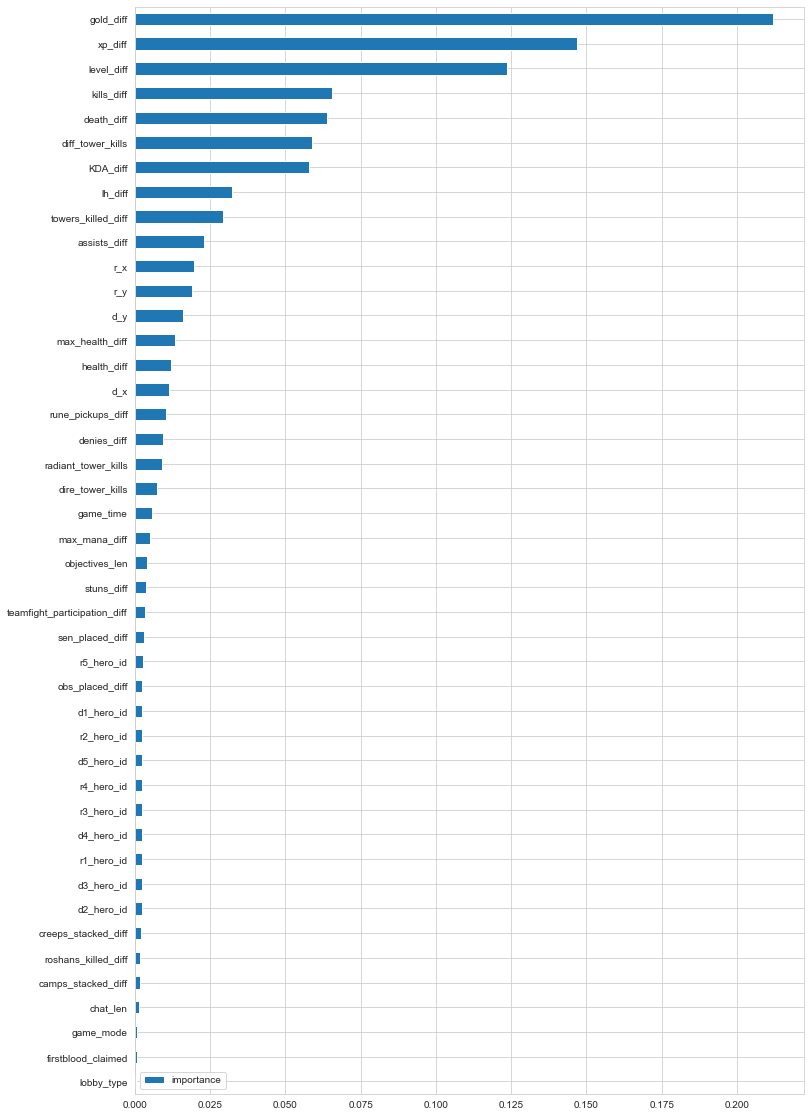

In [29]:
imp = pd.DataFrame(rf_model.feature_importances_, index=df_train_features_extended_Livanova.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 20))

In [ ]:
Посмотрю на скоррелированность получившихся фичей, деревья не любят корреляций, тоже можно наметить, что удалить в дальнейшем.

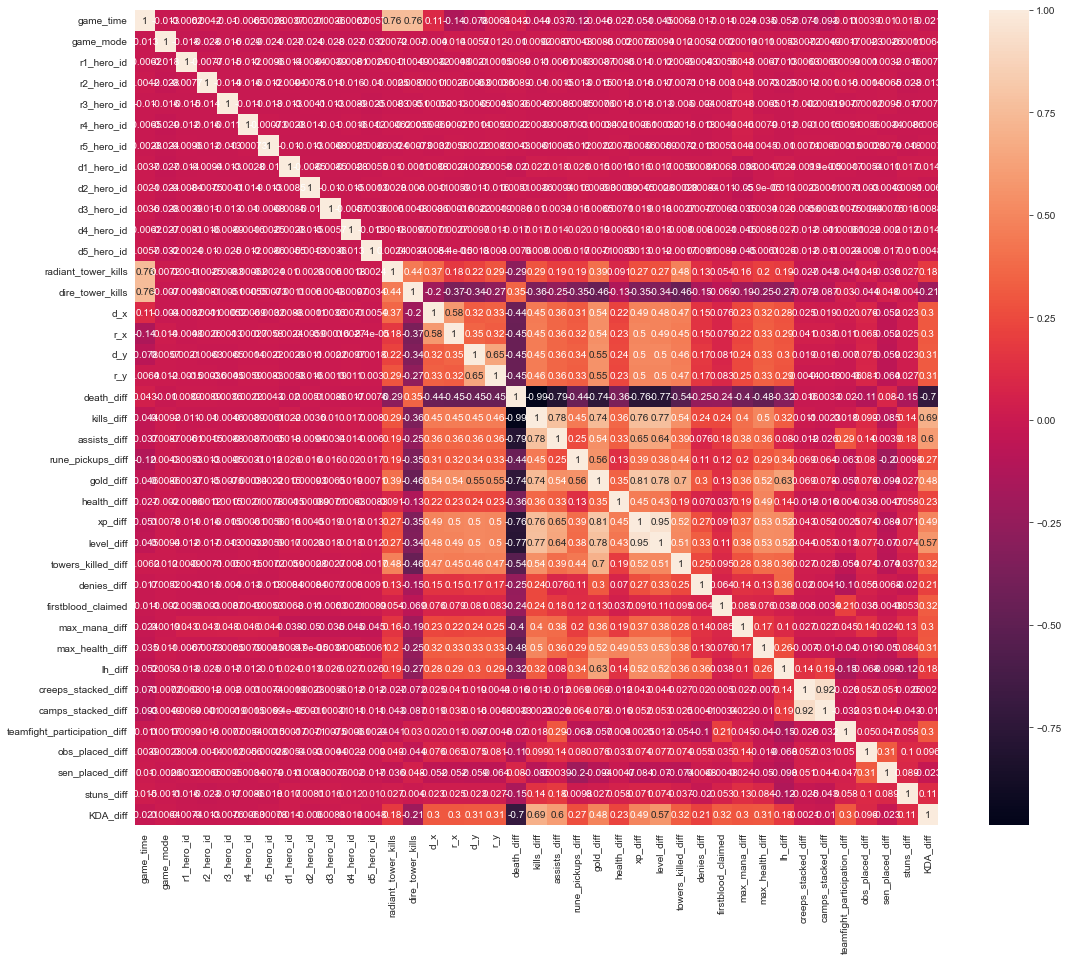

In [228]:

plt.figure(figsize=(18, 15));
ax = sns.heatmap(df_train_features_extended_Livanova.corr(),annot=True,)

Подбор модели. Имрортирую разные классификаторы и считаю на них скор

In [28]:
!pip install catboost
import catboost

In [132]:
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost
import lightgbm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

In [133]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=300, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()


In [134]:
for model in [dt, rf, cat, etc, knn, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb]: 
    model.fit(X_train, y_train)

    valid_score = cross_val_score(model, X_train, y_train, cv=cv,
                                scoring='roc_auc', n_jobs=4)
    print(f"{model.__class__.__name__}: {valid_score.mean()}")

DecisionTreeClassifier: 0.7657257210929526
RandomForestClassifier: 0.8194708813076155
CatBoostClassifier: 0.8226138273363606
ExtraTreesClassifier: 0.8168771373264668
KNeighborsClassifier: 0.7613522770636507
[11:10:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier: 0.806254068896112
LGBMClassifier: 0.8195411314582663
[11:11:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBRFClassifier: 0.8173884180169809
LGBMClassifier: 0.8153500042720863
LogisticRegression: 0.817253607870

Кажется, лучше взять catboost. У него еще можно менять depth, будет немного лучше становиться

In [135]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED, depth=3)
cv_scores_cat = cross_val_score(cat, X_train, y_train, cv=cv,
                                scoring='roc_auc', n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_cat.mean()}")

ROC-AUC на кросс-валидации для новых признаков: nan


In [316]:

cat.fit(X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

## Пробую повозиться с id. 
Для начала создам датасет, в который выпишу все колонки, содержащие id

In [258]:
target_r = pd.Series(df_train_targets['radiant_win'].map({True: 1, False: 0}))
target_d = pd.Series(df_train_targets['radiant_win'].map({True: 0, False: 1}))

In [259]:
ids = df_train_features_extended_Livanova[['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id', 'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id']].copy()
ids['target_r'] = target_r
ids['target_d'] = target_d
ids

,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,d1_hero_id,d2_hero_id,d3_hero_id,d4_hero_id,d5_hero_id,target_r,target_d
match_id_hash,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,15,96,27,63,89,58,14,1,56,92,1,0
6db558535151ea18ca70a6892197db41,101,51,44,49,53,18,67,47,40,17,1,0
19c39fe2af2b547e48708ca005c6ae74,57,10,81,98,119,48,68,60,102,8,0,1
c96d629dc0c39f0c616d1949938a6ba6,119,71,44,35,108,47,98,26,104,90,1,0
156c88bff4e9c4668b0f53df3d870f1b,12,49,91,114,50,51,47,48,119,68,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,99,90,40,67,72,14,86,17,48,102,0,1
308faee28efee2e66b39f9f2ba6ea9cf,22,63,42,21,32,105,59,51,19,31,1,0
6066cc7417b43c749d551e123d00f0c8,1,12,47,42,106,41,119,99,64,97,1,0


Теперь создам отдельные датасеты для каждого участника команды (их 10), где посчитаю сколько раз играл тот или иной id

In [260]:
r1 = ids.groupby('r1_hero_id', as_index=False).agg({'target_r':'count'})
r1 = r1.rename(columns = {'r1_hero_id': 'hero_id'})

r2 = ids.groupby('r2_hero_id', as_index=False).agg({'target_r':'count'})
r2 = r2.rename(columns = {'r2_hero_id': 'hero_id'})

r3 = ids.groupby('r3_hero_id', as_index=False).agg({'target_r':'count'})
r3 = r3.rename(columns = {'r3_hero_id': 'hero_id'})

r4 = ids.groupby('r4_hero_id', as_index=False).agg({'target_r':'count'})
r4 = r4.rename(columns = {'r4_hero_id': 'hero_id'})

r5 = ids.groupby('r5_hero_id', as_index=False).agg({'target_r':'count'})
r5 = r5.rename(columns = {'r5_hero_id': 'hero_id'})

In [261]:



d1 = ids.groupby('d1_hero_id',as_index=False).agg({'target_d':'count'})
d1 = d1.rename(columns = {'d1_hero_id': 'hero_id'})

d2 = ids.groupby('d2_hero_id', as_index=False).agg({'target_d':'count'})
d2= d2.rename(columns = {'d2_hero_id': 'hero_id'})

d3 = ids.groupby('d3_hero_id', as_index=False).agg({'target_d':'count'})
d3 = d3.rename(columns = {'d3_hero_id': 'hero_id'})

d4 = ids.groupby('d4_hero_id', as_index=False).agg({'target_d':'count'})
d4 = d4.rename(columns = {'d4_hero_id': 'hero_id'})

d5 = ids.groupby('d5_hero_id', as_index=False).agg({'target_d':'count'})
d5 = d5.rename(columns = {'d5_hero_id': 'hero_id'})

Соединяю эту информацию в один датасет, в котором будут данные о том, сколько матчей сыграл каждый id героя, будучи взятым каждым из участников

In [262]:
id_matches = r1.merge(r2, on='hero_id', how='outer')
id_matches = id_matches.merge(r3, on='hero_id', how='outer')
id_matches = id_matches.merge(r4, on='hero_id', how='outer')
id_matches = id_matches.merge(r5, on='hero_id', how='outer')
id_matches = id_matches.merge(d1, on='hero_id', how='outer')
id_matches = id_matches.merge(d2, on='hero_id', how='outer')
id_matches = id_matches.merge(d3, on='hero_id', how='outer')
id_matches = id_matches.merge(d4, on='hero_id', how='outer')
id_matches = id_matches.merge(d5, on='hero_id', how='outer')

Ну и конечно, посчитаю общую сумму, сколько матчей провел каждый id

In [264]:
id_matches['matces_sum'] = id_matches.iloc[:, 1] + id_matches.iloc[:, 2] + id_matches.iloc[:, 3] + id_matches.iloc[:, 4] +id_matches.iloc[:, 5] + id_matches.iloc[:, 6] + id_matches.iloc[:, 7] + id_matches.iloc[:, 8] + id_matches.iloc[:, 9] + id_matches.iloc[:, 10]




Теперь похожим образом создам датасеты, в которых будет информация о том, сколько раз выиграл за

In [265]:
r1_win = ids.groupby('r1_hero_id', as_index=False).agg({'target_r':'sum'})
r1_win = r1_win.rename(columns = {'r1_hero_id': 'hero_id'})

r2_win = ids.groupby('r2_hero_id', as_index=False).agg({'target_r':'sum'})
r2_win = r2_win.rename(columns = {'r2_hero_id': 'hero_id'})

r3_win = ids.groupby('r3_hero_id', as_index=False).agg({'target_r':'sum'})
r3_win = r3_win.rename(columns = {'r3_hero_id': 'hero_id'})

r4_win = ids.groupby('r4_hero_id', as_index=False).agg({'target_r':'sum'})
r4_win = r4_win.rename(columns = {'r4_hero_id': 'hero_id'})

r5_win = ids.groupby('r5_hero_id', as_index=False).agg({'target_r':'sum'})
r5_win = r5_win.rename(columns = {'r5_hero_id': 'hero_id'})


In [266]:

d1_win = ids.groupby('d1_hero_id',as_index=False).agg({'target_d':'sum'})
d1_win = d1_win.rename(columns = {'d1_hero_id': 'hero_id'})

d2_win = ids.groupby('d2_hero_id', as_index=False).agg({'target_d':'sum'})
d2_win = d2_win.rename(columns = {'d2_hero_id': 'hero_id'})

d3_win = ids.groupby('d3_hero_id', as_index=False).agg({'target_d':'sum'})
d3_win = d3_win.rename(columns = {'d3_hero_id': 'hero_id'})

d4_win = ids.groupby('d4_hero_id', as_index=False).agg({'target_d':'sum'})
d4_win = d4_win.rename(columns = {'d4_hero_id': 'hero_id'})

d5_win = ids.groupby('d5_hero_id', as_index=False).agg({'target_d':'sum'})
d5_win = d5_win.rename(columns = {'d5_hero_id': 'hero_id'})

In [267]:
id_w = r1_win.merge(r2_win, on='hero_id', how='outer')
id_w = id_w.merge(r3_win, on='hero_id', how='outer')
id_w = id_w.merge(r4_win, on='hero_id', how='outer')
id_w = id_w.merge(r5_win, on='hero_id', how='outer')
id_w = id_w.merge(d1_win, on='hero_id', how='outer')
id_w = id_w.merge(d2_win, on='hero_id', how='outer')
id_w = id_w.merge(d3_win, on='hero_id', how='outer')
id_w = id_w.merge(d4_win, on='hero_id', how='outer')
id_w = id_w.merge(d5_win, on='hero_id', how='outer')

In [268]:
id_w['wins_sum'] = id_w.iloc[:, 1] + id_w.iloc[:, 2] + id_w.iloc[:, 3] + id_w.iloc[:, 4] +id_w.iloc[:, 5] + id_w.iloc[:, 6] + id_w.iloc[:, 7] + id_w.iloc[:, 8] + id_w.iloc[:, 9] + id_w.iloc[:, 10]

In [269]:
ids_summary=id_w[['hero_id', 'wins_sum']].copy()
ids_summary['mathces_sum'] = id_matches['matces_sum']
ids_summary['id_strenght'] = ids_summary['wins_sum']/ids_summary['mathces_sum']
ids_summary = ids_summary.drop(['wins_sum','mathces_sum'], axis=1)
ids_summary

,hero_id,id_strenght
0,1,0.472848
1,2,0.502353
2,3,0.510832
3,4,0.509170
4,5,0.518589
...,...,...
110,112,0.483431
111,113,0.446003
112,114,0.483508
113,119,0.503966


<AxesSubplot:xlabel='id_strenght', ylabel='Density'>

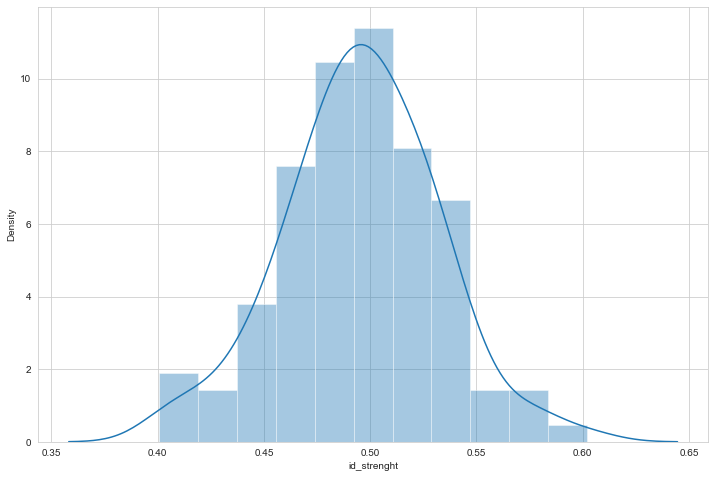

In [270]:
sns.distplot(ids_summary['id_strenght'])

In [271]:
ids_summary= ids_summary.set_index('hero_id')
ids_summary.head(20)

,id_strenght
hero_id,
1,0.472848
2,0.502353
3,0.510832
4,0.509170
5,0.518589
6,0.529869
7,0.480507
8,0.521045
9,0.465463


Заменяю айдишники на вероятность выиграть у этого героя

In [272]:
for i in range(0, 31698):
    df_train_features_extended_Livanova.iloc[i, 5] = ids_summary.loc[df_train_features_extended_Livanova.iloc[i, 5]]

In [273]:
for i in range(0, 31698):
    df_train_features_extended_Livanova.iloc[i, 6] = ids_summary.loc[df_train_features_extended_Livanova.iloc[i, 6]]

In [274]:
for i in range(0, 31698):
    df_train_features_extended_Livanova.iloc[i, 7] = ids_summary.loc[df_train_features_extended_Livanova.iloc[i, 7]]

In [275]:
for i in range(0, 31698):
    df_train_features_extended_Livanova.iloc[i, 8] = ids_summary.loc[df_train_features_extended_Livanova.iloc[i, 8]]

In [276]:
for i in range(0, 31698):
    df_train_features_extended_Livanova.iloc[i, 9] = ids_summary.loc[df_train_features_extended_Livanova.iloc[i, 9]]
    
for i in range(0, 31698):
    df_train_features_extended_Livanova.iloc[i, 10] = ids_summary.loc[df_train_features_extended_Livanova.iloc[i, 10]]

In [277]:
for i in range(0, 31698):
    df_train_features_extended_Livanova.iloc[i, 11] = ids_summary.loc[df_train_features_extended_Livanova.iloc[i, 11]]
    
for i in range(0, 31698):
    df_train_features_extended_Livanova.iloc[i, 12] = ids_summary.loc[df_train_features_extended_Livanova.iloc[i, 12]]

for i in range(0, 31698):
    df_train_features_extended_Livanova.iloc[i, 13] = ids_summary.loc[df_train_features_extended_Livanova.iloc[i, 13]]
    
for i in range(0, 31698):
    df_train_features_extended_Livanova.iloc[i, 14] = ids_summary.loc[df_train_features_extended_Livanova.iloc[i, 14]]

In [278]:
df_train_features_extended_Livanova

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,...,max_mana_diff,max_health_diff,lh_diff,creeps_stacked_diff,camps_stacked_diff,teamfight_participation_diff,obs_placed_diff,sen_placed_diff,stuns_diff,KDA_diff
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,0.479358,0.545319,0.528971,0.503371,0.474359,...,192.00014,680,31,-1,-1,0.375000,-1,1,38.527789,7.125000
6db558535151ea18ca70a6892197db41,21,23,0,0,0,0.522029,0.527214,0.491272,0.518550,0.445614,...,84.00014,-20,0,0,0,0.000000,0,0,0.000000,0.000000
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,0.532962,0.466926,0.541269,0.447745,0.503966,...,24.00003,220,-1,0,0,0.000000,1,0,7.231550,0.000000
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,0.503966,0.517799,0.491272,0.497302,0.550531,...,46.00015,30,50,0,0,0.100000,-1,1,14.696284,-0.650000
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,0.505334,0.518550,0.400759,0.483508,0.485303,...,84.00006,380,30,8,3,0.166667,-2,-1,-40.684134,-2.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,0.530687,0.467043,0.489277,0.577586,0.443043,...,-156.00005,-1460,86,-4,-2,-0.096774,-10,-5,-131.876147,-1.451937
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,0.572719,0.503371,0.545796,0.490237,0.578789,...,1362.00143,-1415,172,-3,0,0.559454,-2,-1,-33.316521,2.137218
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,0.472848,0.505334,0.515546,0.545796,0.435476,...,-795.00084,-935,-38,0,0,-0.071429,-1,0,-34.225366,-5.484127


Проверим предсказание случайного леса и catboost после такого

In [279]:
X = df_train_features_extended_Livanova.values
y = df_train_targets["radiant_win"].values.astype("int8")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict_proba(X_valid)[:, 1]
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.8187448265976653


In [280]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED, depth=3)
cv_scores_cat = cross_val_score(cat, X_train, y_train, cv=cv,
                                scoring='roc_auc', n_jobs=-1)
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_cat.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.8378780761804686


In [ ]:
Ну, успех!

## Пробую дропать. 

Для этого я буду убирать по одному признаку и смотреть, каково значение скора у оставшейся комбинации. Таким образом, я могу выбрать, что удалить первым, если cross-val-score улучшится

In [320]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED, depth=3)
for i in range(len(df_train_features_extended_Livanova.columns)):
    df_train_features_extended_Livanova_cycle = df_train_features_extended_Livanova.copy()
    df_train_features_extended_Livanova_cycle = df_train_features_extended_Livanova_cycle.drop(df_train_features_extended_Livanova.columns[i], axis=1)
    X = df_train_features_extended_Livanova_cycle.values
    y = df_train_targets["radiant_win"].values.astype("int8")
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)
    cv_scores_cat = cross_val_score(cat, X_train, y_train, cv=cv,
                                scoring='roc_auc', n_jobs=-1)
    print(df_train_features_extended_Livanova.columns[i])
    print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_cat.mean()}")

game_time
ROC-AUC на кросс-валидации для новых признаков: 0.8374918469816703
game_mode
ROC-AUC на кросс-валидации для новых признаков: 0.8372799945851244
lobby_type
ROC-AUC на кросс-валидации для новых признаков: 0.8375751198273772
objectives_len
ROC-AUC на кросс-валидации для новых признаков: 0.837659659782711
chat_len
ROC-AUC на кросс-валидации для новых признаков: 0.8375796349846105
r1_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8358735731903323
r2_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8364163113875398
r3_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.836438187436493
r4_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.836468933994756
r5_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8360207740635419
d1_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8353976414269578
d2_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8364008731292533
d3_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.835179

По результатам такой манипуляции , нужно удалить колонку stuns_diff. Удаляем

In [322]:
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['stuns_diff'], axis=1)

И повторяем то же самое

In [333]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED, depth=3)
for i in range(len(df_train_features_extended_Livanova.columns)):
    df_train_features_extended_Livanova_cycle = df_train_features_extended_Livanova.copy()
    df_train_features_extended_Livanova_cycle = df_train_features_extended_Livanova_cycle.drop(df_train_features_extended_Livanova.columns[i], axis=1)
    X = df_train_features_extended_Livanova_cycle.values
    y = df_train_targets["radiant_win"].values.astype("int8")
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)
    cv_scores_cat = cross_val_score(cat, X_train, y_train, cv=cv,
                                scoring='roc_auc', n_jobs=-1)
    print(df_train_features_extended_Livanova.columns[i])
    print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_cat.mean()}")

game_time
ROC-AUC на кросс-валидации для новых признаков: 0.8375394972334037
game_mode
ROC-AUC на кросс-валидации для новых признаков: 0.8374865532981547
lobby_type
ROC-AUC на кросс-валидации для новых признаков: 0.8379054461628772
objectives_len
ROC-AUC на кросс-валидации для новых признаков: 0.8377836952828769
chat_len
ROC-AUC на кросс-валидации для новых признаков: 0.8377995505242103
r1_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8359199675954889
r2_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8361273420192517
r3_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8364074122590303
r4_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8364601723236259
r5_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8357043577935377
d1_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8353818385272763
d2_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8362399927170003
d3_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.835

Дропаем d_y

In [334]:
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['d_y'], axis=1)

In [339]:
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED, depth=3)
for i in range(len(df_train_features_extended_Livanova.columns)):
    df_train_features_extended_Livanova_cycle = df_train_features_extended_Livanova.copy()
    df_train_features_extended_Livanova_cycle = df_train_features_extended_Livanova_cycle.drop(df_train_features_extended_Livanova.columns[i], axis=1)
    X = df_train_features_extended_Livanova_cycle.values
    y = df_train_targets["radiant_win"].values.astype("int8")
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)
    cv_scores_cat = cross_val_score(cat, X_train, y_train, cv=cv,
                                scoring='roc_auc', n_jobs=-1)
    print(df_train_features_extended_Livanova.columns[i])
    print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_cat.mean()}")

game_time
ROC-AUC на кросс-валидации для новых признаков: 0.8373841488387324
game_mode
ROC-AUC на кросс-валидации для новых признаков: 0.8375179280734535
lobby_type
ROC-AUC на кросс-валидации для новых признаков: 0.8377490537026133
objectives_len
ROC-AUC на кросс-валидации для новых признаков: 0.8374476507297308
chat_len
ROC-AUC на кросс-валидации для новых признаков: 0.8379310408573897
r1_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8358505003938059
r2_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8363196248472077
r3_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8365702890375069
r4_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8365978797998144
r5_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8361312014555005
d1_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8354973132997768
d2_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.8364342830916707
d3_hero_id
ROC-AUC на кросс-валидации для новых признаков: 0.834

Тут, похоже, надо дропнуть sen_placed_diff

In [340]:
df_train_features_extended_Livanova = df_train_features_extended_Livanova.drop(['sen_placed_diff'], axis=1)

In [ ]:
Когда решаем остановиться, обучим модель

In [341]:
X = df_train_features_extended_Livanova.values
y = df_train_targets["radiant_win"].values.astype("int8")
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)
cat.fit(X_train, y_train)

## Теперь приедтся провернуть все манипуляции, что я сделала на трейне, с тестовой выборкой

Создаем датасет с тестовыми фичами

In [105]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

In [106]:
df_test_features

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.000000,0,0,0,0,0.000000,0,0,0,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,8.664527,3,1,3,0,0.000000,0,0,2,0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,0.000000,2,1,2,0,0.250000,0,0,0,0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,0.000000,0,0,1,0,0.125000,0,0,0,0
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,0.766459,0,0,1,0,1.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
03f683fed8cf6f03b735e2ee2a942698,509,4,0,1,0,16,2,0,0,1,...,0.000000,3,2,0,0,0.000000,0,0,0,0
06e2b42495855647830ccc6d466f913c,2561,22,7,17,7,76,2,9,1,6,...,149.551700,0,0,20,0,0.395833,0,0,4,0
defd0caeed6ea83d7d5fbdec013fe7d1,1783,22,0,8,23,3,1,9,9,0,...,26.493834,6,2,3,0,0.562500,0,0,7,2


У нас тут 7977 строк, поменяю эти данные в функции и расширю тест так же, как и трейн

In [107]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=7977, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

Подумайте об установке ujson, чтобы работать с JSON объектами быстрее


In [108]:
# Скопируем таблицу с признаками
df_test_features_extended = df_test_features.copy()

# Добавим новые
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))



Теперь в тесте 248 колонок

In [109]:
df_test_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0,0,0.000,0,0,0,0,0.0,0.0,0.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,3,0,0.000,0,0,2,0,0.0,0.0,0.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,2,0,0.250,0,0,0,0,0.0,0.0,0.0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,1,0,0.125,0,0,0,0,1.0,0.0,1.0
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,1,0,1.000,0,0,0,0,0.0,0.0,0.0


Копирую тестовый датасет под своей фамилией, чтобы не качать каждый раз заново при каждом изменении

In [302]:
df_test_features_extended_Livanova= df_test_features_extended.copy()

Теперь точно так же, как и для трейна, все индивидуальные колонки схлопываю в общую для каждой команды (кроме id)

In [303]:
df_test_features_extended_Livanova['r_death_sum'] = df_test_features_extended_Livanova[['r1_deaths','r2_deaths','r3_deaths','r4_deaths', 'r5_deaths']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_deaths','r2_deaths','r3_deaths','r4_deaths', 'r5_deaths'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_death_sum'] = df_test_features_extended_Livanova[['d1_deaths','d2_deaths','d3_deaths','d4_deaths', 'd5_deaths']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_deaths','d2_deaths','d3_deaths','d4_deaths', 'd5_deaths'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_kills_sum'] = df_test_features_extended_Livanova[['d1_kills','d2_kills','d3_kills','d4_kills', 'd5_kills']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_kills','d2_kills','d3_kills','d4_kills', 'd5_kills'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_kills_sum'] = df_test_features_extended_Livanova[['r1_kills','r2_kills','r3_kills','r4_kills', 'r5_kills']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_kills','r2_kills','r3_kills','r4_kills', 'r5_kills'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_assists_sum'] = df_test_features_extended_Livanova[['d1_assists','d2_assists','d3_assists','d4_assists', 'd5_assists']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_assists','d2_assists','d3_assists','d4_assists', 'd5_assists'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_assists_sum'] = df_test_features_extended_Livanova[['r1_assists','r2_assists','r3_assists','r4_assists', 'r5_assists']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_assists','r2_assists','r3_assists','r4_assists', 'r5_assists'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_rune_pickups_sum'] = df_test_features_extended_Livanova[['d1_rune_pickups','d2_rune_pickups','d3_rune_pickups','d4_rune_pickups', 'd5_rune_pickups']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_rune_pickups','d2_rune_pickups','d3_rune_pickups','d4_rune_pickups', 'd5_rune_pickups'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_rune_pickups_sum'] = df_test_features_extended_Livanova[['r1_rune_pickups','r2_rune_pickups','r3_rune_pickups','r4_rune_pickups', 'r5_rune_pickups']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_rune_pickups','r2_rune_pickups','r3_rune_pickups','r4_rune_pickups', 'r5_rune_pickups'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_gold_sum'] = df_test_features_extended_Livanova[['d1_gold','d2_gold','d3_gold','d4_gold', 'd5_gold']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_gold','d2_gold','d3_gold','d4_gold', 'd5_gold'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_gold_sum'] = df_test_features_extended_Livanova[['r1_gold','r2_gold','r3_gold','r4_gold', 'r5_gold']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_gold','r2_gold','r3_gold','r4_gold', 'r5_gold'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_x'] = df_test_features_extended_Livanova[['d1_x','d2_x','d3_x','d4_x', 'd5_x']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_x','d2_x','d3_x','d4_x', 'd5_x'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_x'] = df_test_features_extended_Livanova[['r1_x','r2_x','r3_x','r4_x', 'r5_x']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_x','r2_x','r3_x','r4_x', 'r5_x'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_y'] = df_test_features_extended_Livanova[['d1_y','d2_y','d3_y','d4_y', 'd5_y']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_y','d2_y','d3_y','d4_y', 'd5_y'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_y'] = df_test_features_extended_Livanova[['r1_y','r2_y','r3_y','r4_y', 'r5_y']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_y','r2_y','r3_y','r4_y', 'r5_y'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_health_sum'] = df_test_features_extended_Livanova[['d1_health','d2_health','d3_health','d4_health', 'd5_health']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_health','d2_health','d3_health','d4_health', 'd5_health'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_health_sum'] = df_test_features_extended_Livanova[['r1_health','r2_health','r3_health','r4_health', 'r5_health']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_health','r2_health','r3_health','r4_health', 'r5_health'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_xp_sum'] = df_test_features_extended_Livanova[['d1_xp','d2_xp','d3_xp','d4_xp', 'd5_xp']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_xp','d2_xp','d3_xp','d4_xp', 'd5_xp'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_xp_sum'] = df_test_features_extended_Livanova[['r1_xp','r2_xp','r3_xp','r4_xp', 'r5_xp']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_xp','r2_xp','r3_xp','r4_xp', 'r5_xp'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_level_sum'] = df_test_features_extended_Livanova[['r1_level','r2_level','r3_level','r4_level', 'r5_level']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_level','r2_level','r3_level','r4_level', 'r5_level'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_level_sum'] = df_test_features_extended_Livanova[['d1_level','d2_level','d3_level','d4_level', 'd5_level']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_level','d2_level','d3_level','d4_level', 'd5_level'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_towers_killed_sum'] = df_test_features_extended_Livanova[['r1_towers_killed','r2_towers_killed','r3_towers_killed','r4_towers_killed', 'r5_towers_killed']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_towers_killed','r2_towers_killed','r3_towers_killed','r4_towers_killed', 'r5_towers_killed'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_towers_killed_sum'] = df_test_features_extended_Livanova[['d1_towers_killed','d2_towers_killed','d3_towers_killed','d4_towers_killed', 'd5_towers_killed']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_towers_killed','d2_towers_killed','d3_towers_killed','d4_towers_killed', 'd5_towers_killed'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_denies_sum'] = df_test_features_extended_Livanova[['d1_denies','d2_denies','d3_denies','d4_denies', 'd5_denies']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_denies','d2_denies','d3_denies','d4_denies', 'd5_denies'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_denies_sum'] = df_test_features_extended_Livanova[['r1_denies','r2_denies','r3_denies','r4_denies', 'r5_denies']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_denies','r2_denies','r3_denies','r4_denies', 'r5_denies'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_firstblood_claimed_sum'] = df_test_features_extended_Livanova[['r1_firstblood_claimed','r2_firstblood_claimed','r3_firstblood_claimed','r4_firstblood_claimed', 'r5_firstblood_claimed']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_firstblood_claimed','r2_firstblood_claimed','r3_firstblood_claimed','r4_firstblood_claimed', 'r5_firstblood_claimed'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_firstblood_claimed_sum'] = df_test_features_extended_Livanova[['d1_firstblood_claimed','d2_firstblood_claimed','d3_firstblood_claimed','d4_firstblood_claimed', 'd5_firstblood_claimed']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_firstblood_claimed','d2_firstblood_claimed','d3_firstblood_claimed','d4_firstblood_claimed', 'd5_firstblood_claimed'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_roshans_killed_sum'] = df_test_features_extended_Livanova[['d1_roshans_killed','d2_roshans_killed','d3_roshans_killed','d4_roshans_killed', 'd5_roshans_killed']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_roshans_killed','d2_roshans_killed','d3_roshans_killed','d4_roshans_killed', 'd5_roshans_killed'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_roshans_killed_sum'] = df_test_features_extended_Livanova[['r1_roshans_killed','r2_roshans_killed','r3_roshans_killed','r4_roshans_killed', 'r5_roshans_killed']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_roshans_killed','r2_roshans_killed','r3_roshans_killed','r4_roshans_killed', 'r5_roshans_killed'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_max_mana_sum'] = df_test_features_extended_Livanova[['r1_max_mana','r2_max_mana','r3_max_mana','r4_max_mana', 'r5_max_mana']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_max_mana','r2_max_mana','r3_max_mana','r4_max_mana', 'r5_max_mana'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_max_mana_sum'] = df_test_features_extended_Livanova[['d1_max_mana','d2_max_mana','d3_max_mana','d4_max_mana', 'd5_max_mana']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_max_mana','d2_max_mana','d3_max_mana','d4_max_mana', 'd5_max_mana'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_max_health_sum'] = df_test_features_extended_Livanova[['d1_max_health','d2_max_health','d3_max_health','d4_max_health', 'd5_max_health']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_max_health','d2_max_health','d3_max_health','d4_max_health', 'd5_max_health'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_max_health_sum'] = df_test_features_extended_Livanova[['r1_max_health','r2_max_health','r3_max_health','r4_max_health', 'r5_max_health']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_max_health','r2_max_health','r3_max_health','r4_max_health', 'r5_max_health'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_lh'] = df_test_features_extended_Livanova[['r1_lh','r2_lh','r3_lh','r4_lh', 'r5_lh']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_lh','r2_lh','r3_lh','r4_lh', 'r5_lh'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_lh'] = df_test_features_extended_Livanova[['d1_lh','d2_lh','d3_lh','d4_lh', 'd5_lh']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_lh','d2_lh','d3_lh','d4_lh', 'd5_lh'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_creeps_stacked'] = df_test_features_extended_Livanova[['r1_creeps_stacked','r2_creeps_stacked','r3_creeps_stacked','r4_creeps_stacked', 'r5_creeps_stacked']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_creeps_stacked','r2_creeps_stacked','r3_creeps_stacked','r4_creeps_stacked', 'r5_creeps_stacked'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_creeps_stacked'] = df_test_features_extended_Livanova[['d1_creeps_stacked','d2_creeps_stacked','d3_creeps_stacked','d4_creeps_stacked', 'd5_creeps_stacked']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_creeps_stacked','d2_creeps_stacked','d3_creeps_stacked','d4_creeps_stacked', 'd5_creeps_stacked'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_camps_stacked'] = df_test_features_extended_Livanova[['d1_camps_stacked','d2_camps_stacked','d3_camps_stacked','d4_camps_stacked', 'd5_camps_stacked']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_camps_stacked','d2_camps_stacked','d3_camps_stacked','d4_camps_stacked', 'd5_camps_stacked'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_camps_stacked'] = df_test_features_extended_Livanova[['r1_camps_stacked','r2_camps_stacked','r3_camps_stacked','r4_camps_stacked', 'r5_camps_stacked']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_camps_stacked','r2_camps_stacked','r3_camps_stacked','r4_camps_stacked', 'r5_camps_stacked'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_teamfight_participation'] = df_test_features_extended_Livanova[['r1_teamfight_participation','r2_teamfight_participation','r3_teamfight_participation','r4_teamfight_participation', 'r5_teamfight_participation']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_teamfight_participation','r2_teamfight_participation','r3_teamfight_participation','r4_teamfight_participation', 'r5_teamfight_participation'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_teamfight_participation'] = df_test_features_extended_Livanova[['d1_teamfight_participation','d2_teamfight_participation','d3_teamfight_participation','d4_teamfight_participation', 'd5_teamfight_participation']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_teamfight_participation','d2_teamfight_participation','d3_teamfight_participation','d4_teamfight_participation', 'd5_teamfight_participation'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_obs_placed'] = df_test_features_extended_Livanova[['d1_obs_placed','d2_obs_placed','d3_obs_placed','d4_obs_placed', 'd5_obs_placed']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_obs_placed','d2_obs_placed','d3_obs_placed','d4_obs_placed', 'd5_obs_placed'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_obs_placed'] = df_test_features_extended_Livanova[['r1_obs_placed','r2_obs_placed','r3_obs_placed','r4_obs_placed', 'r5_obs_placed']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_obs_placed','r2_obs_placed','r3_obs_placed','r4_obs_placed', 'r5_obs_placed'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_sen_placed'] = df_test_features_extended_Livanova[['r1_sen_placed','r2_sen_placed','r3_sen_placed','r4_sen_placed', 'r5_sen_placed']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_sen_placed','r2_sen_placed','r3_sen_placed','r4_sen_placed', 'r5_sen_placed'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_sen_placed'] = df_test_features_extended_Livanova[['d1_sen_placed','d2_sen_placed','d3_sen_placed','d4_sen_placed', 'd5_sen_placed']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_sen_placed','d2_sen_placed','d3_sen_placed','d4_sen_placed', 'd5_sen_placed'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['r_stuns'] = df_test_features_extended_Livanova[['r1_stuns','r2_stuns','r3_stuns','r4_stuns', 'r5_stuns']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r1_stuns','r2_stuns','r3_stuns','r4_stuns', 'r5_stuns'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['d_stuns'] = df_test_features_extended_Livanova[['d1_stuns','d2_stuns','d3_stuns','d4_stuns', 'd5_stuns']].sum(axis=1)
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d1_stuns','d2_stuns','d3_stuns','d4_stuns', 'd5_stuns'], axis=1)
df_test_features_extended_Livanova.head()


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,...,d_camps_stacked,r_camps_stacked,r_teamfight_participation,d_teamfight_participation,d_obs_placed,r_obs_placed,r_sen_placed,d_sen_placed,r_stuns,d_stuns
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,78,14,59,77,...,0,0,0.000000,2.0,1,0,0,0,0.000000,0.299948
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,99,101,26,41,...,2,0,2.000000,1.0,3,4,0,0,11.397237,13.663390
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,69,27,104,65,...,1,0,2.500000,1.5,0,0,0,0,15.262940,26.826797
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,95,34,86,104,...,0,0,1.714286,2.5,4,2,0,1,33.025980,4.632218
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,76,32,14,104,...,2,0,1.777778,2.0,3,3,2,2,9.330981,12.830091


Точно так же добавляю KDA

In [304]:
r_KDA = []
for i in range(0, len(df_test_features_extended_Livanova)):
    if df_test_features_extended_Livanova.r_death_sum[i] == 0:
        r_KDA.append(df_test_features_extended_Livanova.r_kills_sum[i] + df_test_features_extended_Livanova.r_assists_sum[i])
    else:
        r_KDA.append((df_test_features_extended_Livanova.r_kills_sum[i] + df_test_features_extended_Livanova.r_assists_sum[i])/df_test_features_extended_Livanova.r_death_sum[i])
    
df_test_features_extended_Livanova['r_KDA']=r_KDA

d_KDA = []
for i in range(0, len(df_test_features_extended_Livanova)):
    if df_test_features_extended_Livanova.d_death_sum[i] == 0:
        d_KDA.append(df_test_features_extended_Livanova.d_kills_sum[i] + df_test_features_extended_Livanova.d_assists_sum[i])
    else:
        d_KDA.append((df_test_features_extended_Livanova.d_kills_sum[i] + df_test_features_extended_Livanova.d_assists_sum[i])/df_test_features_extended_Livanova.d_death_sum[i])
    
df_test_features_extended_Livanova['d_KDA']=d_KDA


И точно так же создаю колонки с разницами по командам вместо отдельных сумм показателей

In [305]:
df_test_features_extended_Livanova['death_diff'] = df_test_features_extended_Livanova['r_death_sum'] - df_test_features_extended_Livanova['d_death_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_death_sum','d_death_sum'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['kills_diff'] = df_test_features_extended_Livanova['r_kills_sum'] - df_test_features_extended_Livanova['d_kills_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_kills_sum','d_kills_sum'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['assists_diff'] = df_test_features_extended_Livanova['r_assists_sum'] - df_test_features_extended_Livanova['d_assists_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_assists_sum','d_assists_sum'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['rune_pickups_diff'] = df_test_features_extended_Livanova['r_rune_pickups_sum'] - df_test_features_extended_Livanova['d_rune_pickups_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_rune_pickups_sum','d_rune_pickups_sum'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['gold_diff'] = df_test_features_extended_Livanova['r_gold_sum'] - df_test_features_extended_Livanova['d_gold_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_gold_sum','d_gold_sum'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['health_diff'] = df_test_features_extended_Livanova['r_health_sum'] - df_test_features_extended_Livanova['d_health_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_health_sum','d_health_sum'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['xp_diff'] = df_test_features_extended_Livanova['r_xp_sum'] - df_test_features_extended_Livanova['d_xp_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_xp_sum','d_xp_sum'], axis=1)
df_test_features_extended_Livanova.head()


df_test_features_extended_Livanova['level_diff'] = df_test_features_extended_Livanova['r_level_sum'] - df_test_features_extended_Livanova['d_level_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_level_sum','d_level_sum'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['towers_killed_diff'] = df_test_features_extended_Livanova['r_towers_killed_sum'] - df_test_features_extended_Livanova['d_towers_killed_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_towers_killed_sum','d_towers_killed_sum'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['denies_diff'] = df_test_features_extended_Livanova['r_denies_sum'] - df_test_features_extended_Livanova['d_denies_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_denies_sum','d_denies_sum'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['firstblood_claimed'] = df_test_features_extended_Livanova['r_firstblood_claimed_sum'] - df_test_features_extended_Livanova['d_firstblood_claimed_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_firstblood_claimed_sum','d_firstblood_claimed_sum'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['roshans_killed_diff'] = df_test_features_extended_Livanova['r_roshans_killed_sum'] - df_test_features_extended_Livanova['d_roshans_killed_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_roshans_killed_sum','d_roshans_killed_sum'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['max_mana_diff'] = df_test_features_extended_Livanova['r_max_mana_sum'] - df_test_features_extended_Livanova['d_max_mana_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_max_mana_sum','d_max_mana_sum'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['max_health_diff'] = df_test_features_extended_Livanova['r_max_health_sum'] - df_test_features_extended_Livanova['d_max_health_sum']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_max_health_sum','d_max_health_sum'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['lh_diff'] = df_test_features_extended_Livanova['r_lh'] - df_test_features_extended_Livanova['d_lh']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_lh','d_lh'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['creeps_stacked_diff'] = df_test_features_extended_Livanova['r_creeps_stacked'] - df_test_features_extended_Livanova['d_creeps_stacked']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_creeps_stacked','d_creeps_stacked'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['camps_stacked_diff'] = df_test_features_extended_Livanova['r_camps_stacked'] - df_test_features_extended_Livanova['d_camps_stacked']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_camps_stacked','d_camps_stacked'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['teamfight_participation_diff'] = df_test_features_extended_Livanova['r_teamfight_participation'] - df_test_features_extended_Livanova['d_teamfight_participation']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_teamfight_participation','d_teamfight_participation'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['obs_placed_diff'] = df_test_features_extended_Livanova['r_obs_placed'] - df_test_features_extended_Livanova['d_obs_placed']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_obs_placed','d_obs_placed'], axis=1)
df_test_features_extended_Livanova.head()


df_test_features_extended_Livanova['sen_placed_diff'] = df_test_features_extended_Livanova['r_sen_placed'] - df_test_features_extended_Livanova['d_sen_placed']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_sen_placed','d_sen_placed'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['stuns_diff'] = df_test_features_extended_Livanova['r_stuns'] - df_test_features_extended_Livanova['d_stuns']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_stuns','d_stuns'], axis=1)
df_test_features_extended_Livanova.head()

df_test_features_extended_Livanova['KDA_diff'] = df_test_features_extended_Livanova['r_KDA'] - df_test_features_extended_Livanova['d_KDA']
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['r_KDA','d_KDA'], axis=1)
df_test_features_extended_Livanova.head()


,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r2_hero_id,r3_hero_id,r4_hero_id,r5_hero_id,...,max_mana_diff,max_health_diff,lh_diff,creeps_stacked_diff,camps_stacked_diff,teamfight_participation_diff,obs_placed_diff,sen_placed_diff,stuns_diff,KDA_diff
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,78,14,59,77,...,-456.00044,0,-7,0,0,-2.000000,-1,0,-0.299948,-2.000000
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,99,101,26,41,...,372.00027,-80,-23,-6,-2,1.000000,1,0,-2.266153,6.714286
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,69,27,104,65,...,406.00040,760,-39,-2,-1,1.000000,0,0,-11.563857,-1.750000
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,95,34,86,104,...,54.00003,-460,12,0,0,-0.785714,-2,-1,28.393762,-0.833333
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,76,32,14,104,...,-406.00044,45,-24,-9,-2,-0.222222,0,0,-3.499110,3.333333


Теперь точно так же обрабатываю айдишники героев

In [306]:
for i in range(0, 7977):
    df_test_features_extended_Livanova.iloc[i, 5] = ids_summary.loc[df_test_features_extended_Livanova.iloc[i, 5]]

In [307]:
for i in range(0, 7977):
    df_test_features_extended_Livanova.iloc[i, 6] = ids_summary.loc[df_test_features_extended_Livanova.iloc[i, 6]]

In [308]:
for i in range(0, 7977):
    df_test_features_extended_Livanova.iloc[i, 7] = ids_summary.loc[df_test_features_extended_Livanova.iloc[i, 7]]

In [309]:
for i in range(0, 7977):
    df_test_features_extended_Livanova.iloc[i, 8] = ids_summary.loc[df_test_features_extended_Livanova.iloc[i, 8]]

In [310]:
for i in range(0, 7977):
    df_test_features_extended_Livanova.iloc[i, 9] = ids_summary.loc[df_test_features_extended_Livanova.iloc[i, 9]]

In [311]:
for i in range(0, 7977):
    df_test_features_extended_Livanova.iloc[i, 10] = ids_summary.loc[df_test_features_extended_Livanova.iloc[i, 10]]

In [312]:
for i in range(0, 7977):
    df_test_features_extended_Livanova.iloc[i, 11] = ids_summary.loc[df_test_features_extended_Livanova.iloc[i, 11]]

In [313]:
for i in range(0, 7977):
    df_test_features_extended_Livanova.iloc[i, 12] = ids_summary.loc[df_test_features_extended_Livanova.iloc[i, 12]]

In [314]:
for i in range(0, 7977):
    df_test_features_extended_Livanova.iloc[i, 13] = ids_summary.loc[df_test_features_extended_Livanova.iloc[i, 13]]

In [315]:
for i in range(0, 7977):
    df_test_features_extended_Livanova.iloc[i, 14] = ids_summary.loc[df_test_features_extended_Livanova.iloc[i, 14]]

не забыли дропнуть те же колонки,ч тодропнули у трейна

In [324]:
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['stuns_diff'], axis=1)

In [336]:
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['d_y'], axis=1)

In [342]:
df_test_features_extended_Livanova = df_test_features_extended_Livanova.drop(['sen_placed_diff'], axis=1)

Проверим, что колонки совпадают

In [343]:
 df_test_features_extended_Livanova.columns ==  df_train_features_extended_Livanova.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [344]:
 df_test_features_extended_Livanova.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id',
       'd1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id',
       'radiant_tower_kills', 'dire_tower_kills', 'diff_tower_kills', 'd_x',
       'r_x', 'r_y', 'death_diff', 'kills_diff', 'assists_diff',
       'rune_pickups_diff', 'gold_diff', 'health_diff', 'xp_diff',
       'level_diff', 'towers_killed_diff', 'denies_diff', 'firstblood_claimed',
       'roshans_killed_diff', 'max_mana_diff', 'max_health_diff', 'lh_diff',
       'creeps_stacked_diff', 'camps_stacked_diff',
       'teamfight_participation_diff', 'obs_placed_diff', 'KDA_diff'],
      dtype='object')

## Можно создавать посылку для каггла!

In [345]:
X_test = df_test_features_extended_Livanova.values
y_test_pred = cat.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [346]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-24_16-42-55.csv
